In [1]:
import os
from functools import partial 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from scipy.stats import spearmanr
from matplotlib_venn import venn3
import secstructartist as ssa
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import sklearn.ensemble
import json

# file with functions used to plot figures
from plotting_funcs import *
from ML_funcs import *

In [2]:
# define data

leh_data = pd.read_csv('./data/leh_data.csv', index_col=0)
adh_data = pd.read_csv('./data/adh_data.csv', index_col=0)
hmfo_data = pd.read_csv('./data/hmfo_data.csv', index_col=0)
leh_data_newmuts = pd.read_csv('./data/leh_data_newmuts.csv', index_col=0)

leh_data_u = leh_data.copy()
for i in leh_data_newmuts.index:
    leh_data_u.loc[i, 'exp_tested'] = True
    leh_data_u.loc[i,'stabilizing'] = leh_data_newmuts.loc[i].dTm > 0
    leh_data_u.loc[i, 'dtm'] = leh_data_newmuts.loc[i].dTm

boostmut_cols = [i for i in adh_data.columns if i not in ['exp_tested', 'stabilizing', 'dtm']]

# all ADH mutations
adh_data_x_a = adh_data[boostmut_cols].values
adh_data_yc_a = adh_data.stabilizing.values
adh_data_yr_a = adh_data.dtm.values
# just experimentally tested mutations 
adh_data_x_e = adh_data[adh_data.exp_tested][boostmut_cols].values
adh_data_yc_e = adh_data[adh_data.exp_tested].stabilizing.values
adh_data_yr_e = adh_data[adh_data.exp_tested].dtm.values

# all LEH mutations
leh_data_x_a = leh_data_u[boostmut_cols].values
leh_data_yc_a = leh_data_u.stabilizing.values
leh_data_yr_a = leh_data_u.dtm.values
# just experimentally tested mutations 
leh_data_x_e = leh_data_u[leh_data_u.exp_tested][boostmut_cols].values
leh_data_yc_e = leh_data_u[leh_data_u.exp_tested].stabilizing.values
leh_data_yr_e = leh_data_u[leh_data_u.exp_tested].dtm.values.astype(float)

# all HMFO mutations
hmfo_data_x_a = hmfo_data[boostmut_cols].values
hmfo_data_yc_a = hmfo_data.stabilizing.values
hmfo_data_yr_a = hmfo_data.dtm.values
# just experimentally tested mutations 
hmfo_data_x_e = hmfo_data[hmfo_data.stabilizing][boostmut_cols].values
hmfo_data_yc_e = hmfo_data[hmfo_data.stabilizing].stabilizing.values
hmfo_data_yr_e = hmfo_data[hmfo_data.stabilizing].dtm.values

# all data combined
X_a = np.vstack((leh_data_x_a, adh_data_x_a, hmfo_data_x_a,))
yc_a = np.concatenate((leh_data_yc_a, adh_data_yc_a, hmfo_data_yc_a,))
yr_a = np.concatenate((leh_data_yr_a, adh_data_yr_a, hmfo_data_yr_a,))
yr_a[yr_a == '-'] = 0
yr_a = yr_a.astype(float)
yr_a[np.isnan(yr_a)] = 0
# all experimentally tested mutations combined
X_e = np.vstack([leh_data_x_e, adh_data_x_e, hmfo_data_x_e])
yc_e = np.concatenate([leh_data_yc_e, adh_data_yc_e, hmfo_data_yc_e])
yr_e = np.concatenate((leh_data_yr_e, adh_data_yr_e, hmfo_data_yr_e))

In [3]:
# optimize hyperparameters
rs = 42
model_names = ['SVC', 'KNC', 'RFC', 'SVR','ridge', 'RFR']
class_reg = ['classifier', 'classifier', 'classifier', 'regressor', 'regressor', 'regressor']

models = [sklearn.svm.SVC(probability=True, random_state=rs), 
          KNeighborsClassifier(), 
          sklearn.ensemble.RandomForestClassifier(random_state=rs),
          sklearn.svm.SVR(kernel='linear'),
          sklearn.linear_model.Ridge(random_state=rs),
          sklearn.ensemble.RandomForestRegressor(random_state=rs),]

param_grids = {'SVC':{'C': [0.1, 1, 10],'gamma': [0.01, 0.1, 1],'kernel': ['rbf', 'linear']},
               'KNC':{'n_neighbors': [3, 5, 7, 11],'weights': ['uniform', 'distance']},
               'RFC':{'n_estimators': [50, 100], 'max_depth': [2,3,5,10], 'min_samples_split': [2, 5],
                      'min_samples_leaf': [2, 3, 5], 'max_features': ['sqrt'], 'class_weight': ['balanced', None]},
               'SVR':{'C': [0.1, 1, 10],'gamma': [0.01, 0.1, 1],'kernel': ['rbf', 'linear']},
               'ridge':{'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
               'RFR':{'n_estimators': [50, 100], 'max_depth': [2,3,5,10], 'min_samples_split': [2, 5],
                      'min_samples_leaf': [2, 3, 5], 'max_features': ['sqrt'],}}   

# do a grid search of hyperparameters, optimizing for both AUC/wAUC after performing k-fold cross validation
hyperparams_a = optimize_params(models, param_grids, model_names, class_reg, X_a, yc_a, yr_a, rs=42)
hyperparams_e = optimize_params(models, param_grids, model_names, class_reg, X_e, yc_e, yr_e, rs=42)

SVC
0.6662232431191984
0.6919064916302373
0.6979567252135245
0.6979763766135794
SVC {'C': 1, 'gamma': 1, 'kernel': 'rbf'} 0.6979763766135794
KNC
0.7159523141311811
0.7261805330366491
0.7350158149867857
0.738992383493926
0.7431119350023467
0.7501769834480367
KNC {'n_neighbors': 11, 'weights': 'distance'} 0.7501769834480367
RFC
0.7510905572916673
0.756304514484698
0.7569088562926349
0.7671815197037981
0.7696107734255208
0.7735274646584422
0.774653974477463
0.7759068763536305
0.7791634641324996
RFC {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced'} 0.7791634641324996
SVR
0.5947427983423285
0.5993194005028007
SVR {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'} 0.5993194005028007
ridge
0.6427662445846407
0.6427742929494642
0.6436948314269686
0.6474237605162031
ridge {'alpha': 100.0} 0.6474237605162031
RFR
0.5957270085157296
0.596065527796162
0.5974797939802354
RFR {'n_estimators': 100, 'max_depth': 2, 'min_

(108, 15) (108,) (108,)
(397, 15) (397,) (397,)
(746, 15) (746,) (746,)
(1251, 15) (1251,) (1251,)
(1251, 15) (1251,) (1251,)
using optimized hyperparameters
mean [0.6059150212831743, 0.6785913709884003]
SVC [0.688535234775258, 0.7074175184519006]
KNC [0.7309180392396732, 0.7694359276564002]
RFC [0.7648304386969124, 0.7934964895680865]


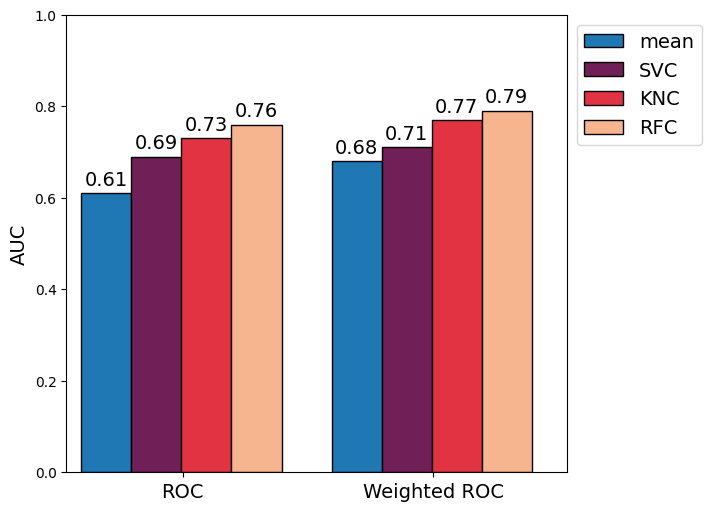

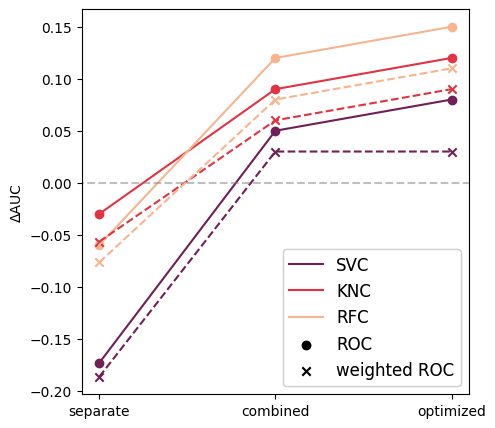

In [4]:
# prepare data for all mutations
data_dict_a = {'LEH':[leh_data_x_a, leh_data_yc_a, leh_data_yr_a],
               'ADH':[adh_data_x_a, adh_data_yc_a, adh_data_yr_a], 
               'HMFO':[hmfo_data_x_a, hmfo_data_yc_a, hmfo_data_yr_a]}
# prepare classifier models
models_a = ['mean',
            sklearn.svm.SVC(probability=True, random_state=rs), 
            KNeighborsClassifier(), 
            sklearn.ensemble.RandomForestClassifier(random_state=rs),]

# load in the correct hyperparameters
with open('./hyperparams/best_hyperparams_LEH_ADH_HMFO_allmuts.json', 'r') as f:
    hyperparams_a = json.load(f)

# define selections, whether they are classifiers/regressors, and model names
selections = ['LEH', 'ADH', 'HMFO', 'LEH_ADH_HMFO', 'LEH_ADH_HMFO_opt']
class_reg_a = ['mean', 'classifier', 'classifier', 'classifier']
model_names_a = ['mean', 'SVC', 'KNC', 'RFC']

# perform k-fold cross validation, plot absolute AUC for final selection, and compare changes in AUCs for each scenario
aucs_sels_a, waucs_sels_a = compare_scenarios(models_a, model_names_a, class_reg_a, data_dict_a, selections, hyperparams_a)
plot_aucs_ml(model_names_a, aucs_sels_a[-1], waucs_sels_a[-1], name_out='./figures/fig_9-auc_clas.png')
plot_scenarios(aucs_sels_a, waucs_sels_a, model_names_a, scenarios=['separate', 'combined', 'optimized'], 
               combine=3, name_out='./figures/fig_9-ML_clas_optim.png')

(60, 15) (60,) (60,)
(140, 15) (140,) (140,)
(216, 15) (216,) (216,)
(216, 15) (216,) (216,)
using optimized hyperparameters
mean [0.6010936434255395, 0.668999460821716]
SVR [0.6244535809018565, 0.6948179359741105]
ridge [0.6366862447896928, 0.6989588230995522]
RFR [0.6088139446760134, 0.6462653031030172]


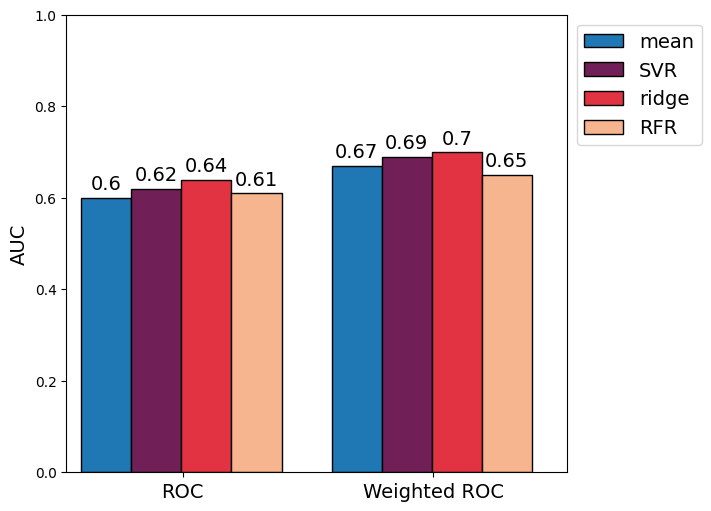

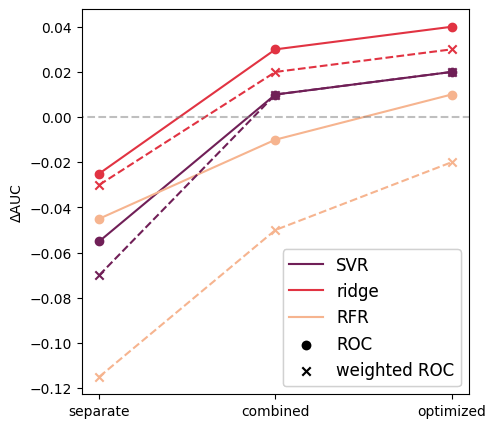

In [5]:
# prepare data for all experimentally tested mutations
data_dict_e = {'LEH':[leh_data_x_e, leh_data_yc_e, leh_data_yr_e],
               'ADH':[adh_data_x_e, adh_data_yc_e, adh_data_yr_e], 
               'HMFO':[hmfo_data_x_e, hmfo_data_yc_e, hmfo_data_yr_e]}
# prepare regressor models
models_e = ['mean',
            sklearn.svm.SVR(kernel='linear'),
            sklearn.linear_model.Ridge(random_state=rs,),
            sklearn.ensemble.RandomForestRegressor(random_state=rs,)]

# load in the correct hyperparameters
with open('./hyperparams/best_hyperparams_LEH_ADH_HMFO_expmuts.json', 'r') as f:
    hyperparams_e = json.load(f)

# define selections, whether they are classifiers/regressors, and model names
selections = ['LEH', 'ADH', 'LEH_ADH_HMFO', 'LEH_ADH_HMFO_opt']
class_reg_e = ['mean', 'regressor', 'regressor', 'regressor']
model_names_e = ['mean', 'SVR','ridge', 'RFR']


# perform k-fold cross validation, plot absolute AUC for final selection, and compare changes in AUCs for each scenario
aucs_sels_e, waucs_sels_e = compare_scenarios(models_e, model_names_e, class_reg_e, data_dict_e, selections, hyperparams_e)
plot_aucs_ml(model_names_e, aucs_sels_e[-1], waucs_sels_e[-1], name_out='./figures/fig_9-auc_reg.png')
plot_scenarios(aucs_sels_e, waucs_sels_e, model_names_e, scenarios=['separate', 'combined', 'optimized'], 
               combine=2, name_out='./figures/fig_9-ML_reg_optim.png')